In [11]:
# Cell 2 — Imports & configuration
import os
import math
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from transformers import AutoModel, AutoImageProcessor
import timm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- CONFIG ----------------
class Config:
    # Colab-friendly default paths (change if needed)
    BASE_DIR = "dataset_split"   # your dataset: train/ validation/ test/ folders
    GFT_MODEL_PATH = "gft/best_full_gft_gala_pps.pth" # path to your saved GFT model (upload to Colab)
    IMG_SIZE = 224
    BATCH_SIZE = 16     # reduce if OOM
    NUM_WORKERS = 0
    COATNET_MODEL = "coatnet_0_rw_224"
    PRETRAINED_COATNET = True
    SAVE_DIR = "checkpoints_fusion_v3"
    os.makedirs(SAVE_DIR, exist_ok=True)

    # training phases
    HEAD_EPOCHS = 6
    PARTIAL_EPOCHS = 18
    FULL_EPOCHS = 50

    HEAD_LR = 3e-4
    PARTIAL_LR = 5e-5
    FULL_LR = 5e-6

    WEIGHT_DECAY = 0.05
    LR_WARMUP_EPOCHS = 3
    PATIENCE = 8

    MIXUP_ALPHA = 0.3
    SPEC_AUG_FREQ = 20
    SPEC_AUG_TIME = 30
    DROP_RATE = 0.4

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print("Device:", config.DEVICE)
print("Dataset base dir:", config.BASE_DIR)
print("GFT checkpoint (expected):", config.GFT_MODEL_PATH)


Device: cuda
Dataset base dir: dataset_split
GFT checkpoint (expected): gft/best_full_gft_gala_pps.pth


In [2]:
# %%
# Cell 3 (REVISED) — Model definitions with Standard Cross-Attention

# --- GALA_Attention and GFT_Encoder_Minimal are unchanged ---
class GALA_Attention(nn.Module):
    def __init__(self, dim, n_heads=6, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % n_heads == 0; self.n_heads = n_heads; self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5; self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop); self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.focal_gamma = nn.Parameter(torch.ones(n_heads, 1, 1))
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn_w = torch.softmax(attn, dim=-1)
        focal = torch.pow(1.0 - attn_w, self.focal_gamma)
        attn_mod = attn_w * focal
        attn_mod = attn_mod / (attn_mod.sum(dim=-1, keepdim=True) + 1e-6)
        out = (self.attn_drop(attn_mod) @ v).transpose(1,2).reshape(B,N,C)
        return self.proj_drop(self.proj(out))

class GFT_Encoder_Minimal(nn.Module):
    # ... (code is the same, omitted for brevity)
    def __init__(self, embed_dim, num_stages=3, n_heads=6, drop_rate=0.3):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(nn.LayerNorm(embed_dim), GALA_Attention(embed_dim, n_heads=n_heads),
                          nn.LayerNorm(embed_dim), nn.Linear(embed_dim, embed_dim), nn.GELU(), nn.Dropout(drop_rate)
            ) for _ in range(num_stages)])
    def forward(self, x):
        for s in self.stages: x = s(x)
        return x

class DinoV2_GFT_Minimal(nn.Module):
    # ... (code is the same, omitted for brevity)
    def __init__(self, model_name="facebook/dinov2-small", num_classes=10, gft_stages=3, n_heads=6, drop_rate=0.3):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        embed_dim = self.backbone.config.hidden_size
        self.embed_dim = embed_dim
        self.gft_encoder = GFT_Encoder_Minimal(embed_dim, num_stages=gft_stages)
        self.pool_norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Sequential(nn.Linear(embed_dim, 512), nn.GELU(), nn.Dropout(drop_rate), nn.Linear(512, 256), nn.GELU(), nn.Dropout(drop_rate*0.5), nn.Linear(256, num_classes))
    def forward(self, pixel_values, token_mask=None):
        tokens = self.backbone(pixel_values=pixel_values).last_hidden_state
        if token_mask is not None: tokens = tokens * token_mask.unsqueeze(-1)
        features = self.gft_encoder(tokens)
        pooled = self.pool_norm(torch.mean(features, dim=1))
        return self.classifier(pooled)


# --- NEW: Fusion model with a standard nn.MultiheadAttention block ---
class GFT_CoAtNet_Fusion_v3(nn.Module):
    def __init__(self, gft_checkpoint_path, num_classes, coatnet_name, coatnet_pretrained, proj_dim=768, drop_rate=0.4):
        super().__init__()
        # gft branch (loaded from checkpoint, strict=False handles any minor mismatches)
        self.gft_branch = DinoV2_GFT_Minimal(num_classes=num_classes)
        if gft_checkpoint_path and os.path.exists(gft_checkpoint_path):
            print("Loading GFT checkpoint...")
            self.gft_branch.load_state_dict(torch.load(gft_checkpoint_path, map_location="cpu"), strict=False)
            print("GFT weights loaded.")
        
        # coatnet branch
        self.coatnet = timm.create_model(coatnet_name, pretrained=coatnet_pretrained, num_classes=0, global_pool="avg")
        coat_dim = self.coatnet.num_features
        gft_dim = self.gft_branch.embed_dim

        # Projection heads
        self.gft_proj = nn.Sequential(nn.Linear(gft_dim, proj_dim), nn.LayerNorm(proj_dim))
        self.coat_proj = nn.Sequential(nn.Linear(coat_dim, proj_dim), nn.LayerNorm(proj_dim))

        # --- UPGRADED CROSS-ATTENTION ---
        # Using the powerful, standard MultiheadAttention module from PyTorch
        self.cross_attention = nn.MultiheadAttention(embed_dim=proj_dim, num_heads=8, batch_first=True)
        self.cross_norm = nn.LayerNorm(proj_dim)

        # Final classifier
        fusion_in = proj_dim * 2 # We'll concatenate the GFT features and the cross-attention output
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_in, 1024), nn.GELU(), nn.Dropout(drop_rate),
            nn.Linear(1024, 512), nn.GELU(), nn.Dropout(drop_rate*0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, token_mask=None):
        # --- GFT Branch ---
        gft_tokens = self.gft_branch.backbone(pixel_values=x).last_hidden_state
        if token_mask is not None: gft_tokens = gft_tokens * token_mask.unsqueeze(-1)
        gft_feats = self.gft_branch.gft_encoder(gft_tokens)
        gft_pooled = torch.mean(gft_feats, dim=1)
        gft_proj = self.gft_proj(gft_pooled)

        # --- CoAtNet Branch ---
        coat_feats = self.coatnet(x)
        coat_proj = self.coat_proj(coat_feats)

        # --- Standard Cross-Attention Fusion ---
        # GFT provides the query, CoAtNet provides the context (key, value)
        # We add a sequence dimension (unsqueeze) for the attention module and remove it after (squeeze)
        cross_out, _ = self.cross_attention(
            query=gft_proj.unsqueeze(1),
            key=coat_proj.unsqueeze(1),
            value=coat_proj.unsqueeze(1)
        )
        cross_out = self.cross_norm(cross_out.squeeze(1))

        # --- Final Concatenation & Classification ---
        # We combine the original GFT feature with the context-aware feature from cross-attention
        fused = torch.cat([gft_proj, cross_out], dim=1)
        logits = self.fusion_head(fused)
        return logits

In [4]:
# Cell 4 — dataset, transforms, dataloaders
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split="train", transform=None):
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        if not os.path.isdir(self.data_dir):
            raise FileNotFoundError(f"Directory not found: {self.data_dir}")
        self.classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        self.paths, self.labels = [], []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".png",".jpg",".jpeg")):
                    self.paths.append(os.path.join(cls_dir, f))
                    self.labels.append(self.class_to_idx[cls])
        print(f"Found {len(self.paths)} images in {split} with {len(self.classes)} classes.")

    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform: img = self.transform(img)
        return img, label

# transforms using DINOv2 processor normalization
proc = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
mean, std = proc.image_mean, proc.image_std

train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
val_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = MelSpectrogramDataset(config.BASE_DIR, "train", train_transform)
val_dataset = MelSpectrogramDataset(config.BASE_DIR, "val", val_transform)
test_dataset = MelSpectrogramDataset(config.BASE_DIR, "test", val_transform)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)

num_classes = len(train_dataset.classes)
print("Num classes:", num_classes)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Found 2825 images in train with 5 classes.
Found 350 images in val with 5 classes.
Found 359 images in test with 5 classes.
Num classes: 5


In [5]:
# Cell 5 — augment, mixup, loss helpers
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param=20, time_mask_param=30):
        super().__init__()
        self.F = freq_mask_param
        self.T = time_mask_param
    def forward(self, x):
        B,C,H,W = x.shape
        # freq masks (height)
        f = np.random.randint(0, min(self.F, H)+1)
        if f>0:
            f0 = np.random.randint(0, max(1, H - f))
            x[:, :, f0:f0+f, :] = 0
        # time masks (width)
        t = np.random.randint(0, min(self.T, W)+1)
        if t>0:
            t0 = np.random.randint(0, max(1, W - t))
            x[:, :, :, t0:t0+t] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=config.SPEC_AUG_FREQ, time_mask_param=config.SPEC_AUG_TIME)

def mixup_data(x, y, alpha=0.3, device="cuda"):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# loss
class GradientFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(logits, targets, reduction="none")
        p = torch.exp(-ce)
        probs = torch.softmax(logits, dim=1)
        target_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        grad_weight = torch.abs(target_probs - 1.0)
        focal = self.alpha * (1 - p) ** self.gamma * (1 + grad_weight)
        loss = focal * ce
        return loss.mean() if self.reduction=="mean" else loss.sum()


In [6]:
# Cell 6 — train and validation functions (AMP)
scaler = torch.cuda.amp.GradScaler()

def train_epoch(model, dataloader, criterion, optimizer, device, mixup_alpha=0.0, spec_aug=True):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    pbar = tqdm(dataloader, desc="Train")
    for imgs, labels in pbar:
        imgs = imgs.to(device); labels = labels.to(device)
        if spec_aug:
            imgs = spec_augment(imgs)
        if mixup_alpha > 0:
            inputs, targets_a, targets_b, lam = mixup_data(imgs, labels, mixup_alpha, device)
        else:
            inputs, targets_a, targets_b, lam = imgs, labels, labels, 1.0

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model(inputs)
            loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Val")
        for imgs, labels in pbar:
            imgs = imgs.to(device); labels = labels.to(device)
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                loss = criterion(logits, labels)
            running_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


In [7]:
# %%
# Cell 7 — Phase 1: Train Fusion Head
# Creates model, freezes large parts, trains only projection heads + fusion head.

# CORRECTED: Changed to the new class name GFT_CoAtNet_Fusion_v3
model = GFT_CoAtNet_Fusion_v3(
    gft_checkpoint_path=config.GFT_MODEL_PATH,
    num_classes=num_classes,
    coatnet_name=config.COATNET_MODEL,
    coatnet_pretrained=config.PRETRAINED_COATNET,
    drop_rate=config.DROP_RATE
).to(config.DEVICE)
print("Model created.")

# Freeze both branches initially
for p in model.gft_branch.parameters(): p.requires_grad = False
for p in model.coatnet.parameters(): p.requires_grad = False

# Enable projections + fusion head
for p in model.gft_proj.parameters(): p.requires_grad = True
for p in model.coat_proj.parameters(): p.requires_grad = True
for p in model.cross_attention.parameters(): p.requires_grad = True # Updated from model.cross
for p in model.fusion_head.parameters(): p.requires_grad = True

# Prepare optimizer and criterion
criterion = GradientFocalLoss(alpha=0.25, gamma=2.0)
opt_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(opt_params, lr=config.HEAD_LR, weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.HEAD_EPOCHS - config.LR_WARMUP_EPOCHS))

best_val = 0.0
for epoch in range(config.HEAD_EPOCHS):
    print(f"\nHEAD PHASE Epoch {epoch+1}/{config.HEAD_EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, mixup_alpha=0.0, spec_aug=True)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.DEVICE)
    scheduler.step()
    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
    if val_acc > best_val:
        best_val = val_acc
        save_path = os.path.join(config.SAVE_DIR, "best_head_fusion_v3.pth") # Updated save name
        torch.save(model.state_dict(), save_path)
        print("Saved best head:", save_path)

print("Head training done. Best val:", best_val)

Model created.

HEAD PHASE Epoch 1/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2253 Acc 0.6704 | Val Loss 0.1653 Acc 0.7286
Saved best head: checkpoints_fusion_v3\best_head_fusion_v3.pth

HEAD PHASE Epoch 2/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1732 Acc 0.7147 | Val Loss 0.1272 Acc 0.7857
Saved best head: checkpoints_fusion_v3\best_head_fusion_v3.pth

HEAD PHASE Epoch 3/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1510 Acc 0.7427 | Val Loss 0.1113 Acc 0.7943
Saved best head: checkpoints_fusion_v3\best_head_fusion_v3.pth

HEAD PHASE Epoch 4/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1438 Acc 0.7519 | Val Loss 0.1123 Acc 0.8029
Saved best head: checkpoints_fusion_v3\best_head_fusion_v3.pth

HEAD PHASE Epoch 5/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1512 Acc 0.7465 | Val Loss 0.1018 Acc 0.8200
Saved best head: checkpoints_fusion_v3\best_head_fusion_v3.pth

HEAD PHASE Epoch 6/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1682 Acc 0.7182 | Val Loss 0.1209 Acc 0.7943
Head training done. Best val: 0.82


In [8]:
# %%
# Cell 8 — Phase 2: Partial fine-tune (CORRECTED)
# Load best head and unfreeze selective parts of coatnet and last GFT stage

# --- CORRECTED --- Load the v3 head checkpoint
head_ckpt = os.path.join(config.SAVE_DIR, "best_head_fusion_v3.pth")
if os.path.exists(head_ckpt):
    model.load_state_dict(torch.load(head_ckpt, map_location=config.DEVICE), strict=False)
    print("Loaded head checkpoint.")
else:
    print("Head checkpoint not found; continuing with current model state.")

# Unfreeze coatnet
for name, p in model.coatnet.named_parameters():
    p.requires_grad = True

# Unfreeze last GFT stage parameters
for name, p in model.gft_branch.named_parameters():
    if "stages.2" in name or "stages.{}".format(len(model.gft_branch.gft_encoder.stages)-1) in name:
        p.requires_grad = True
    else:
        if "gft_encoder" in name:
            p.requires_grad = False

# Ensure projection & fusion remain trainable
for p in model.gft_proj.parameters(): p.requires_grad = True
for p in model.coat_proj.parameters(): p.requires_grad = True
# --- CORRECTED --- Changed model.cross to model.cross_attention
for p in model.cross_attention.parameters(): p.requires_grad = True
for p in model.fusion_head.parameters(): p.requires_grad = True

# Prepare optimizer with LR groups
param_groups = [
    {"params": model.fusion_head.parameters(), "lr": config.PARTIAL_LR},
    {"params": model.gft_proj.parameters(), "lr": config.PARTIAL_LR},
    {"params": model.coat_proj.parameters(), "lr": config.PARTIAL_LR},
    {"params": model.cross_attention.parameters(), "lr": config.PARTIAL_LR}, # Also add cross_attention to a group
    {"params": [p for n,p in model.gft_branch.named_parameters() if p.requires_grad], "lr": config.PARTIAL_LR * 0.5},
    {"params": model.coatnet.parameters(), "lr": config.PARTIAL_LR * 0.5}
]
optimizer = optim.AdamW(param_groups, weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.PARTIAL_EPOCHS - config.LR_WARMUP_EPOCHS))

# Re-initialize best_val for this phase
best_val = 0.0
epochs_no_improve = 0
for epoch in range(config.PARTIAL_EPOCHS):
    print(f"\nPARTIAL PHASE Epoch {epoch+1}/{config.PARTIAL_EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, mixup_alpha=config.MIXUP_ALPHA, spec_aug=True)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.DEVICE)
    scheduler.step()
    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
    if val_acc > best_val:
        best_val = val_acc
        epochs_no_improve = 0
        # --- CORRECTED --- Update save path to v3
        save_path = os.path.join(config.SAVE_DIR, "best_partial_fusion_v3.pth")
        torch.save(model.state_dict(), save_path)
        print("Saved best partial:", save_path)
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= config.PATIENCE:
        print("Early stopping (partial) triggered.")
        break

print("Partial training done. Best val:", best_val)

Loaded head checkpoint.

PARTIAL PHASE Epoch 1/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2217 Acc 0.5621 | Val Loss 0.1195 Acc 0.7914
Saved best partial: checkpoints_fusion_v3\best_partial_fusion_v3.pth

PARTIAL PHASE Epoch 2/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2019 Acc 0.5791 | Val Loss 0.1321 Acc 0.7971
Saved best partial: checkpoints_fusion_v3\best_partial_fusion_v3.pth

PARTIAL PHASE Epoch 3/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1887 Acc 0.5770 | Val Loss 0.1170 Acc 0.7629

PARTIAL PHASE Epoch 4/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1896 Acc 0.6120 | Val Loss 0.0958 Acc 0.8400
Saved best partial: checkpoints_fusion_v3\best_partial_fusion_v3.pth

PARTIAL PHASE Epoch 5/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1716 Acc 0.6081 | Val Loss 0.0928 Acc 0.8343

PARTIAL PHASE Epoch 6/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1650 Acc 0.6283 | Val Loss 0.0887 Acc 0.8457
Saved best partial: checkpoints_fusion_v3\best_partial_fusion_v3.pth

PARTIAL PHASE Epoch 7/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1734 Acc 0.6025 | Val Loss 0.0848 Acc 0.8457

PARTIAL PHASE Epoch 8/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1637 Acc 0.5958 | Val Loss 0.0834 Acc 0.8714
Saved best partial: checkpoints_fusion_v3\best_partial_fusion_v3.pth

PARTIAL PHASE Epoch 9/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1507 Acc 0.5763 | Val Loss 0.0805 Acc 0.8400

PARTIAL PHASE Epoch 10/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1439 Acc 0.6411 | Val Loss 0.0750 Acc 0.8714

PARTIAL PHASE Epoch 11/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1481 Acc 0.6368 | Val Loss 0.0797 Acc 0.8371

PARTIAL PHASE Epoch 12/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1372 Acc 0.6361 | Val Loss 0.0835 Acc 0.8571

PARTIAL PHASE Epoch 13/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1423 Acc 0.6050 | Val Loss 0.0772 Acc 0.8543

PARTIAL PHASE Epoch 14/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1309 Acc 0.6389 | Val Loss 0.0726 Acc 0.8629

PARTIAL PHASE Epoch 15/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1397 Acc 0.6542 | Val Loss 0.0729 Acc 0.8600

PARTIAL PHASE Epoch 16/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1324 Acc 0.6081 | Val Loss 0.0737 Acc 0.8629
Early stopping (partial) triggered.
Partial training done. Best val: 0.8714285714285714


In [12]:
# Cell 9 — Phase 3: Full fine-tune (unfreeze everything and train)
# Load best partial if exists
partial_ckpt = os.path.join(config.SAVE_DIR, "best_partial_fusion_v3.pth")
if os.path.exists(partial_ckpt):
    model.load_state_dict(torch.load(partial_ckpt, map_location=config.DEVICE), strict=False)
    print("Loaded partial checkpoint.")
else:
    print("Partial checkpoint not found; continuing from current model.")

# Unfreeze all params
for p in model.parameters(): p.requires_grad = True

# optimizer and scheduler (lower LR)
optimizer = optim.AdamW(model.parameters(), lr=config.FULL_LR, weight_decay=config.WEIGHT_DECAY*0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.FULL_EPOCHS - config.LR_WARMUP_EPOCHS))

best_val = 0.0
epochs_no_improve = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(config.FULL_EPOCHS):
    print(f"\nFULL PHASE Epoch {epoch+1}/{config.FULL_EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE, mixup_alpha=config.MIXUP_ALPHA, spec_aug=True)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, config.DEVICE)
    scheduler.step()
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
    if val_acc > best_val:
        best_val = val_acc
        epochs_no_improve = 0
        save_path = os.path.join(config.SAVE_DIR, "best_full_fusion_v3.pth")
        torch.save(model.state_dict(), save_path)
        print("Saved best full:", save_path)
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= config.PATIENCE:
        print("Early stopping (full) triggered.")
        break

print("Full training done. Best val:", best_val)
# optional: save training history
hist_path = os.path.join(config.SAVE_DIR, "history_fusion_v3.npy")
np.save(hist_path, history)
print("Saved history:", hist_path)


Loaded partial checkpoint.

FULL PHASE Epoch 1/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1588 Acc 0.6212 | Val Loss 0.0806 Acc 0.8543
Saved best full: checkpoints_fusion_v3\best_full_fusion_v3.pth

FULL PHASE Epoch 2/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1451 Acc 0.6184 | Val Loss 0.0733 Acc 0.8543

FULL PHASE Epoch 3/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1463 Acc 0.6004 | Val Loss 0.0764 Acc 0.8486

FULL PHASE Epoch 4/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1473 Acc 0.5724 | Val Loss 0.0763 Acc 0.8543

FULL PHASE Epoch 5/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1420 Acc 0.6304 | Val Loss 0.0798 Acc 0.8571
Saved best full: checkpoints_fusion_v3\best_full_fusion_v3.pth

FULL PHASE Epoch 6/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1495 Acc 0.6156 | Val Loss 0.0762 Acc 0.8686
Saved best full: checkpoints_fusion_v3\best_full_fusion_v3.pth

FULL PHASE Epoch 7/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1371 Acc 0.6117 | Val Loss 0.0734 Acc 0.8600

FULL PHASE Epoch 8/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1374 Acc 0.6432 | Val Loss 0.0843 Acc 0.8657

FULL PHASE Epoch 9/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1326 Acc 0.5986 | Val Loss 0.0728 Acc 0.8543

FULL PHASE Epoch 10/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1413 Acc 0.6223 | Val Loss 0.0794 Acc 0.8543

FULL PHASE Epoch 11/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1345 Acc 0.6262 | Val Loss 0.0760 Acc 0.8600

FULL PHASE Epoch 12/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1373 Acc 0.6230 | Val Loss 0.0803 Acc 0.8714
Saved best full: checkpoints_fusion_v3\best_full_fusion_v3.pth

FULL PHASE Epoch 13/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1355 Acc 0.6442 | Val Loss 0.0735 Acc 0.8600

FULL PHASE Epoch 14/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1268 Acc 0.6173 | Val Loss 0.0741 Acc 0.8457

FULL PHASE Epoch 15/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1275 Acc 0.6379 | Val Loss 0.0749 Acc 0.8514

FULL PHASE Epoch 16/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1221 Acc 0.6184 | Val Loss 0.0798 Acc 0.8657

FULL PHASE Epoch 17/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1272 Acc 0.6205 | Val Loss 0.0844 Acc 0.8629

FULL PHASE Epoch 18/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1382 Acc 0.5993 | Val Loss 0.0774 Acc 0.8686

FULL PHASE Epoch 19/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1232 Acc 0.6181 | Val Loss 0.0707 Acc 0.8743
Saved best full: checkpoints_fusion_v3\best_full_fusion_v3.pth

FULL PHASE Epoch 20/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1264 Acc 0.6421 | Val Loss 0.0746 Acc 0.8629

FULL PHASE Epoch 21/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1263 Acc 0.6588 | Val Loss 0.0826 Acc 0.8600

FULL PHASE Epoch 22/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1282 Acc 0.6418 | Val Loss 0.0785 Acc 0.8571

FULL PHASE Epoch 23/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1251 Acc 0.6237 | Val Loss 0.0762 Acc 0.8657

FULL PHASE Epoch 24/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1178 Acc 0.6478 | Val Loss 0.0745 Acc 0.8600

FULL PHASE Epoch 25/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1298 Acc 0.6407 | Val Loss 0.0815 Acc 0.8514

FULL PHASE Epoch 26/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1186 Acc 0.6389 | Val Loss 0.0840 Acc 0.8543

FULL PHASE Epoch 27/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1238 Acc 0.6138 | Val Loss 0.0746 Acc 0.8571
Early stopping (full) triggered.
Full training done. Best val: 0.8742857142857143
Saved history: checkpoints_fusion_v3\history_fusion_v3.npy


Evaluating checkpoint: checkpoints_fusion_v3\best_full_fusion_v3.pth


Testing:   0%|          | 0/23 [00:00<?, ?it/s]


Test Accuracy: 0.8524 (85.24%)

Classification Report:
                precision    recall  f1-score   support

          Mild     0.6765    0.6389    0.6571        36
      Moderate     0.7800    0.8211    0.8000        95
         No_DR     0.9888    0.9779    0.9833       181
Proliferate_DR     0.7727    0.6071    0.6800        28
        Severe     0.4583    0.5789    0.5116        19

      accuracy                         0.8524       359
     macro avg     0.7353    0.7248    0.7264       359
  weighted avg     0.8573    0.8524    0.8535       359



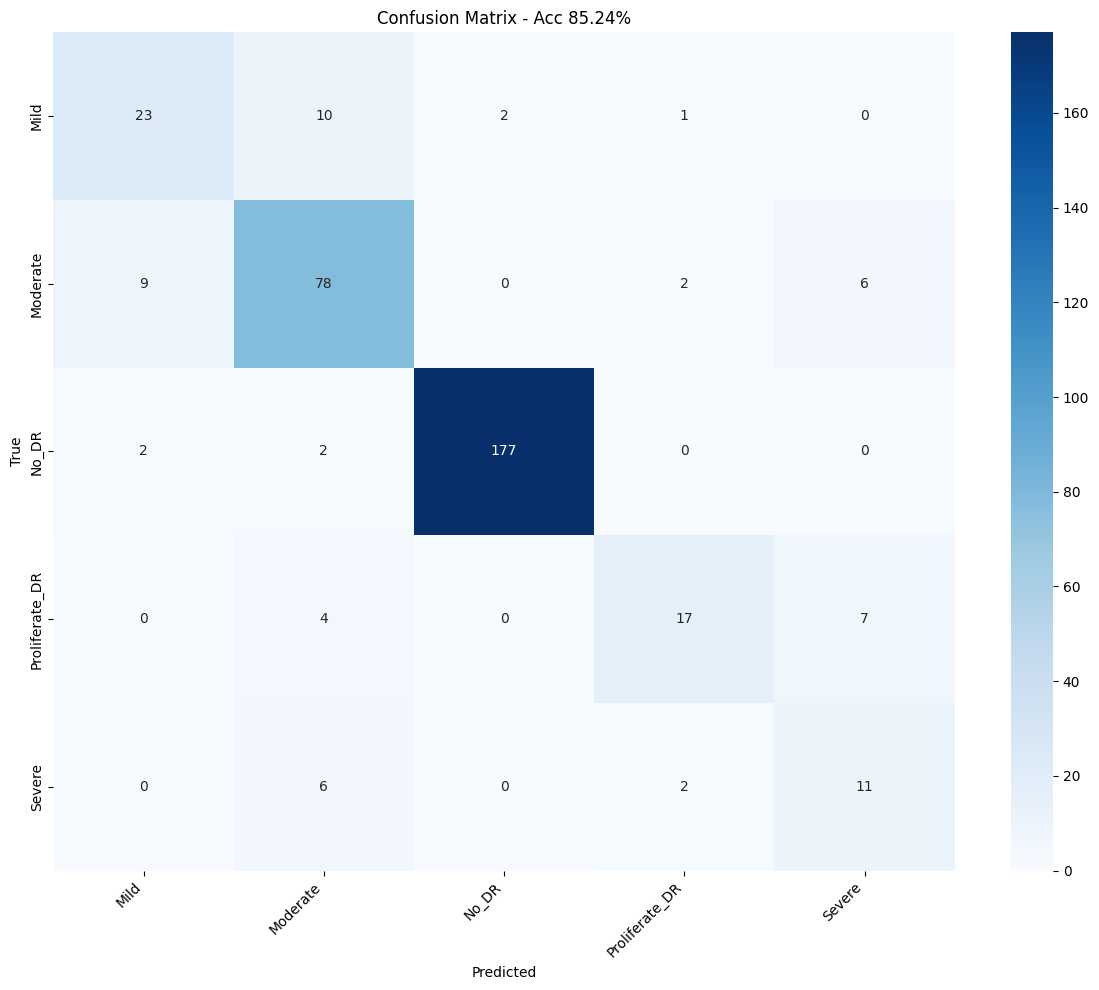

In [13]:
# %%
# Cell 10 — Testing + classification report + confusion matrix (CORRECTED)

# --- CORRECTED --- Look for v3 checkpoints first
ckpt_candidate = os.path.join(config.SAVE_DIR, "best_full_fusion_v3.pth")
if not os.path.exists(ckpt_candidate):
    # Fallback options, also updated to v3
    for f in ["best_partial_fusion_v3.pth", "best_head_fusion_v3.pth"]:
        p = os.path.join(config.SAVE_DIR, f)
        if os.path.exists(p):
            ckpt_candidate = p
            break

print("Evaluating checkpoint:", ckpt_candidate)

# Instantiate model skeleton and load weights
# --- CORRECTED --- Changed to the new class name GFT_CoAtNet_Fusion_v3
eval_model = GFT_CoAtNet_Fusion_v3(
    gft_checkpoint_path=config.GFT_MODEL_PATH,
    num_classes=num_classes,
    coatnet_name=config.COATNET_MODEL,
    coatnet_pretrained=config.PRETRAINED_COATNET,
    drop_rate=config.DROP_RATE
).to(config.DEVICE)

eval_state = torch.load(ckpt_candidate, map_location=config.DEVICE)
eval_model.load_state_dict(eval_state, strict=False)
eval_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    pbar = tqdm(test_loader, desc="Testing")
    for imgs, labels in pbar:
        imgs = imgs.to(config.DEVICE)
        labels = labels.to(config.DEVICE)
        with torch.cuda.amp.autocast():
            logits = eval_model(imgs)
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix - Acc {acc*100:.2f}%")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()